In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# This class generates the price, delta, and gamma of an option

class BS():
   
    def priceCall(self, S, K, sigma, r, T):
        d_plus = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d_minus = (np.log(S/K) + (r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        price = S*norm.cdf(d_plus) - K*np.exp(-r*T)*norm.cdf(d_minus)
        return price

    def deltaCall(self, S, K, sigma, r, T):
        d_plus = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.cdf(d_plus)

    def gammaCall(self, S, K, sigma, r, T):
        d_plus = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.pdf(d_plus)/(S*sigma*np.sqrt(T))       

        

In [3]:
# This class contains the hedging dynamics and simulation for delta hedging and delta-gamma hedging

class Hedger():
    def __init__(self, pos = 10000, S0=10, K_g=10, T_g=0.25, K_h=10, T_h = 0.3, 
                 r=0.05, mu=0.1, sigma_imp=0.25, sigma_real=0.25, 
                 Ndt=63*4+1, k = 0.005, BS = BS()):
        self.pos = pos # number of options we sell
        self.S0 = S0
        self.K_g = K_g
        self.K_h = K_h
        self.T_g = T_g
        self.T_h = T_h
        
        self.r = r
        self.sigma_imp = sigma_imp # implied vol used to price option
        self.sigma_real = sigma_real # realized vol by the price paths
        self.mu = mu
        self.k = k   #transaction cost
        
        self.Ndt = Ndt
        self.t = np.linspace(0, T_g, Ndt)
        self.dt = self.t[1] - self.t[0]
        self.BS = BS

    # Method used to generate sample price paths using Geometric Brownian Motion
    def generate_asset_paths(self, num_paths):
        S = np.zeros((num_paths, self.Ndt))
        S[:, 0] = self.S0
        for i in range(1, self.Ndt):
            dW = np.sqrt(self.dt) * np.random.randn(num_paths)
            S[:, i] = S[:,i-1] * np.exp((self.mu - 0.5*self.sigma_real**2) * self.dt + dW * self.sigma_real)
        return S

    # Method used to compute the delta of g at each time and along each price path
    def generate_delta_hedge(self, S, num_paths):
        delta = np.zeros((num_paths, self.Ndt))
        delta[:, 0] = self.BS.deltaCall(S[:, 0], self.K_g, self.sigma_imp, self.r, self.T_g)
        for i in range(1, self.Ndt-1):
            delta[:, i] = self.BS.deltaCall(S[:, i], self.K_g, self.sigma_imp, self.r, self.T_g - self.t[i])
        return delta

    # Method used to simulate delta hedging
    def delta_hedge_sim(self, S, num_paths):
        delta = self.generate_delta_hedge(S, num_paths)
        M = np.zeros((num_paths, self.Ndt))
        g_init_price = self.BS.priceCall(self.S0, self.K_g, self.sigma_imp, self.r, self.T_g)

        alpha = np.zeros((num_paths, self.Ndt))
        for i in range(self.Ndt):
            alpha[:, i] = np.round(delta[:, i]*self.pos,0) # alpha stores the number of shares needed to hedge the delta
        M[:, 0] = self.pos*g_init_price - S[:,0]*alpha[:,0]
        for i in range(1, self.Ndt):
            if i < self.Ndt - 1:
                M[:, i] = M[:, i-1]*np.exp(self.r*self.dt) - S[:, i]*(alpha[:, i] - alpha[:, i-1]) - np.abs((alpha[:,i]-alpha[:,i-1]))*self.k
            else:
                M[:, i] = M[:, i-1]*np.exp(self.r*self.dt) + alpha[:, i-1]*S[:, i]\
                - self.pos*np.maximum(S[:, i] - self.K_g, np.zeros(num_paths)) - np.abs(alpha[:,i-1])*self.k
        return alpha, M

    # Method used to compute the delta and gamma of g and h at each time step, along each price path
    def generate_delta_gamma_hedge(self, S, num_paths):        
        delta_g = np.zeros((num_paths, self.Ndt))
        delta_h =  np.zeros((num_paths, self.Ndt))
        delta_g[:, 0] = self.BS.deltaCall(S[:, 0], self.K_g, self.sigma_imp, self.r, self.T_g)
        delta_h[:, 0] = self.BS.deltaCall(S[:, 0], self.K_h, self.sigma_imp, self.r, self.T_h)
        for i in range(1, self.Ndt-1):
            delta_g[:, i] = self.BS.deltaCall(S[:, i], self.K_g, self.sigma_imp, self.r, self.T_g - self.t[i])
        for i in range(1, self.Ndt-1):
            delta_h[:, i] = self.BS.deltaCall(S[:, i], self.K_h, self.sigma_imp, self.r, self.T_h - self.t[i])

        gamma_g = np.zeros((num_paths, self.Ndt))
        gamma_h =  np.zeros((num_paths, self.Ndt))
        gamma_g[:, 0] = self.BS.gammaCall(S[:, 0], self.K_g, self.sigma_imp, self.r, self.T_g)
        gamma_h[:, 0] = self.BS.gammaCall(S[:, 0], self.K_h, self.sigma_imp, self.r, self.T_h)
        for i in range(1, self.Ndt-1):
            gamma_g[:, i] = self.BS.gammaCall(S[:, i], self.K_g, self.sigma_imp, self.r, self.T_g - self.t[i])
        for i in range(1, self.Ndt-1):
            gamma_h[:, i] = self.BS.gammaCall(S[:, i], self.K_h, self.sigma_imp, self.r, self.T_h - self.t[i])

        return delta_g, delta_h, gamma_g, gamma_h
    
    # Method used to simulate delta and gamma hedging
    def delta_gamma_hedge_sim(self, S, num_paths):
        delta_g, delta_h, gamma_g, gamma_h = self.generate_delta_gamma_hedge(S, num_paths)
        
        # h is the price of option h based on the time, and price of the underlying
        h = np.zeros((num_paths, self.Ndt))
        for i in range(self.Ndt):
            h[:, i] = self.BS.priceCall(S[:, i], self.K_h, self.sigma_imp, self.r, self.T_h - self.t[i])
        
        M = np.zeros((num_paths, self.Ndt))
        g_init_price = self.BS.priceCall(self.S0, self.K_g, self.sigma_imp, self.r, self.T_g)

        #omega is the position in the option h, since gamma is being used already
        alpha = np.zeros((num_paths, self.Ndt))
        omega = np.zeros((num_paths, self.Ndt))

        for i in range(self.Ndt-1):
            alpha[:, i] = np.round(self.pos*(delta_g[:, i] - gamma_g[:, i]/gamma_h[:, i]*delta_h[:, i]),0)
            omega[:, i] = np.round(self.pos*gamma_g[:, i]/gamma_h[:, i],0)

        M[:, 0] = self.pos*g_init_price - S[:,0]*alpha[:, 0] - h[:, 0]*omega[:, 0]
        for i in range(1, self.Ndt):
            if i < self.Ndt - 1:
                M[:, i] = M[:, i-1]*np.exp(self.r*self.dt) - S[:, i]*(alpha[:, i] - alpha[:, i-1]) - h[:, i]*(omega[:, i] - omega[:, i-1]) \
                - np.abs(alpha[:,i]-alpha[:,i-1])*self.k - np.abs(omega[:,i]-omega[:,i-1])*self.k
            else:
                M[:, i] = M[:, i-1]*np.exp(self.r*self.dt) + alpha[:, i-1] * S[:, i] + omega[:, i-1] * h[:, i] \
                - self.pos*np.maximum(S[:, i] - self.K_g, np.zeros(num_paths)) \
                - np.abs(alpha[:,i-1])*self.k - np.abs(omega[:,i-1])*self.k
    
        return alpha, omega, M

In [8]:
def get_profits(mu, k):
    
    n_paths = 5000
    
    hedger = Hedger(mu = mu, pos=10000, k=k)
    paths = hedger.generate_asset_paths(n_paths) # generate price paths
    alpha_d,  M_d = hedger.delta_hedge_sim(paths, n_paths) # simulate delta hedging
    alpha_dg, omega_dg,  M_dg = hedger.delta_gamma_hedge_sim(paths, n_paths) # simulate delta-gamma hedging
    
    profits_d = M_d[:,-1]
    profits_dg = M_dg[:,-1]

    return profits_d, profits_dg

def get_profits(vol_real, k):
    
    n_paths = 5000
    
    hedger = Hedger(sigma_real = vol_real, pos=10000, k=k)
    paths = hedger.generate_asset_paths(n_paths) # generate price paths
    alpha_d,  M_d = hedger.delta_hedge_sim(paths, n_paths) # simulate delta hedging
    alpha_dg, omega_dg,  M_dg = hedger.delta_gamma_hedge_sim(paths, n_paths) # simulate delta-gamma hedging
    
    profits_d = M_d[:,-1]
    profits_dg = M_dg[:,-1]

    return profits_d, profits_dg


In [5]:
mus = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
profits_mu_d = []
profits_mu_dg = []
k= 0.005

for mu in mus:
    a, b = get_profits(mu, k)
    profits_mu_d.append(a)
    profits_mu_dg.append(b)

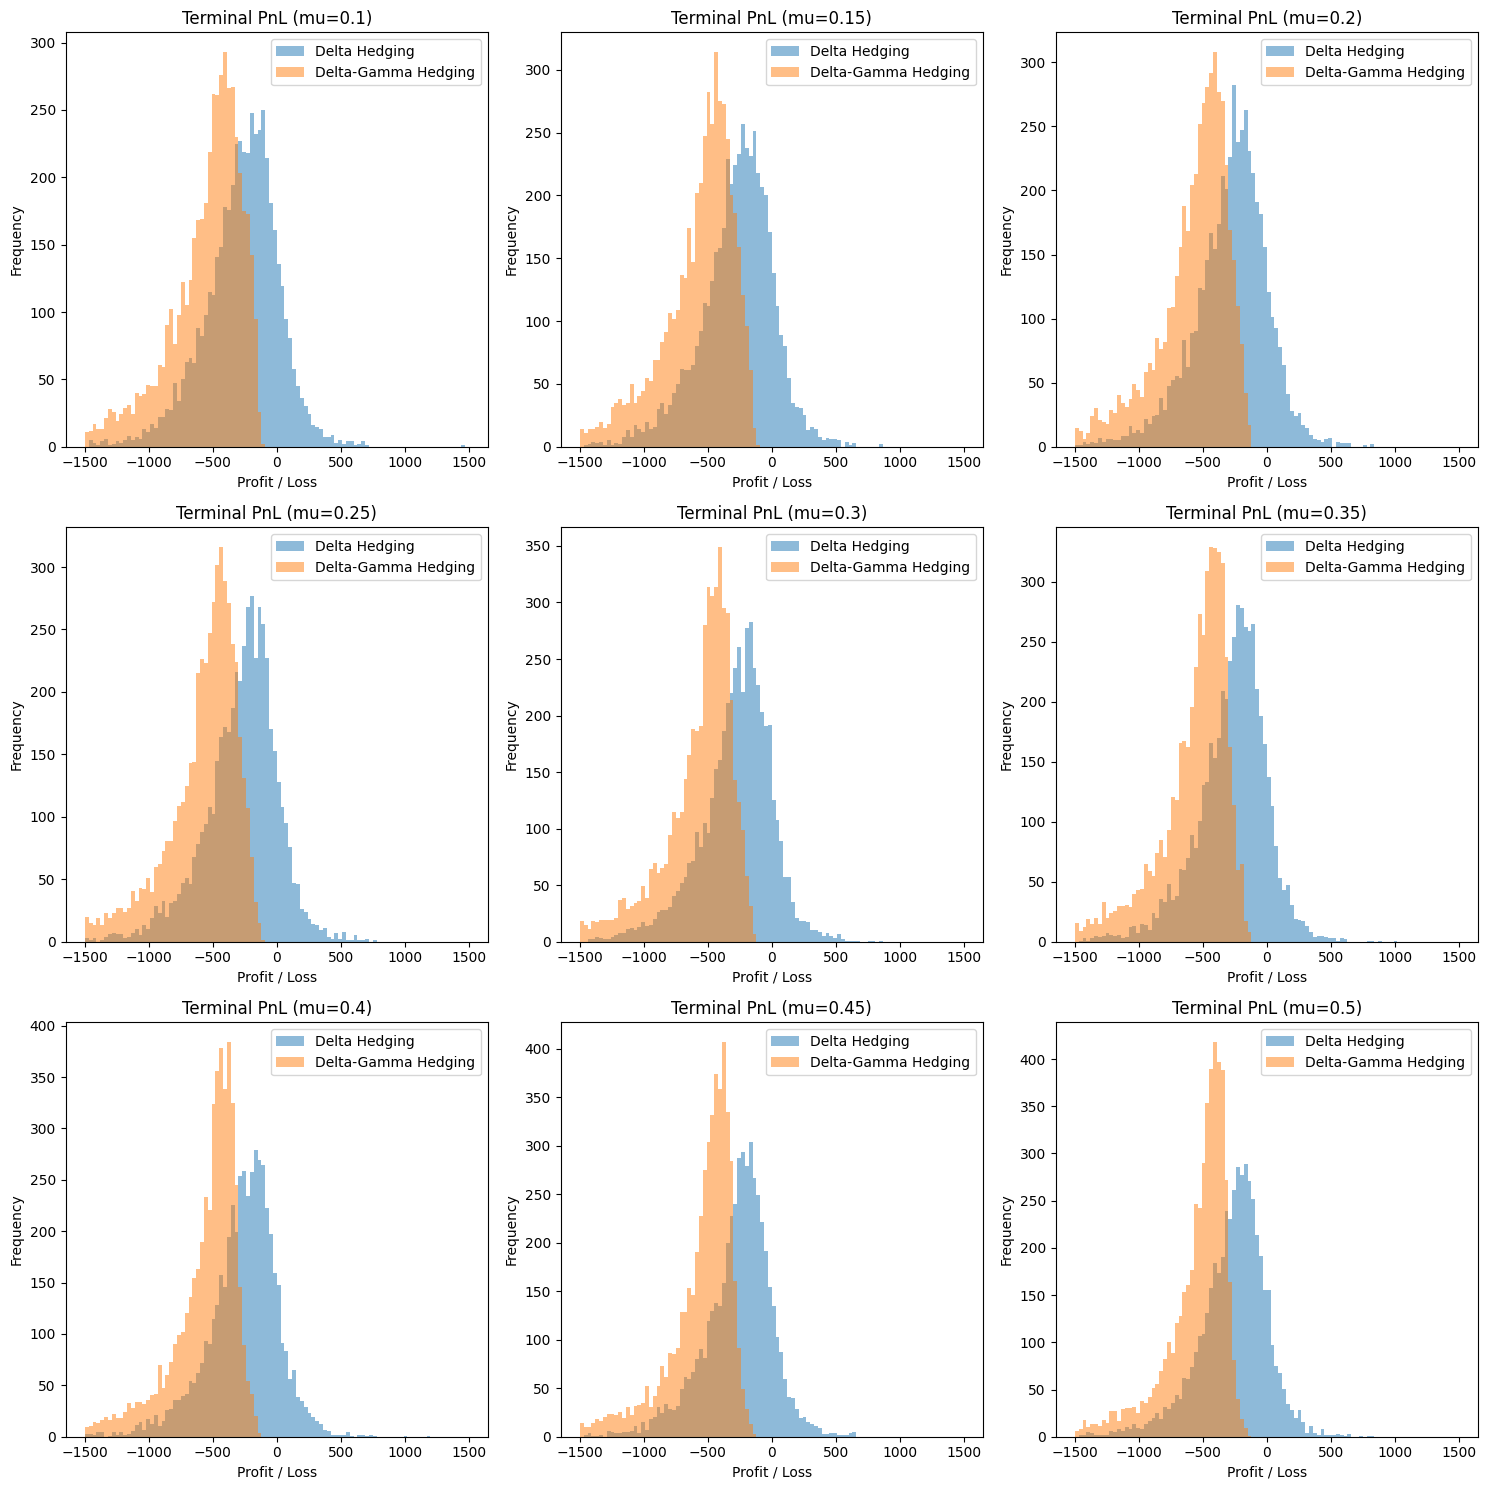

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))




for i in range(len(mus)):
    row = i // 3
    col = i % 3

    axs[row, col].hist(profits_mu_d[i], bins=np.linspace(-1500, 1500, 101), alpha=0.5, label='Delta Hedging')
    axs[row, col].hist(profits_mu_dg[i], bins=np.linspace(-1500, 1500, 101), alpha=0.5, label='Delta-Gamma Hedging')
    axs[row, col].set_xlabel('Profit / Loss')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Terminal PnL (mu={mus[i]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

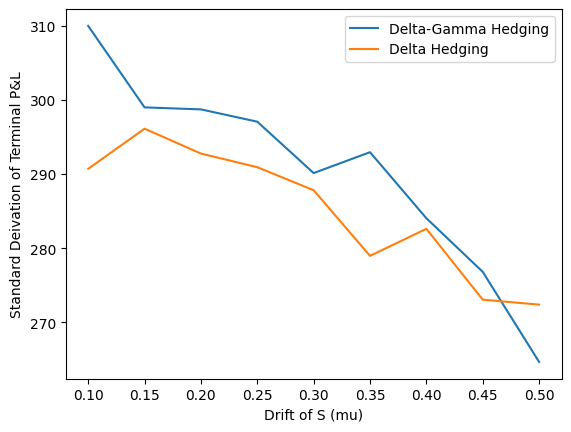

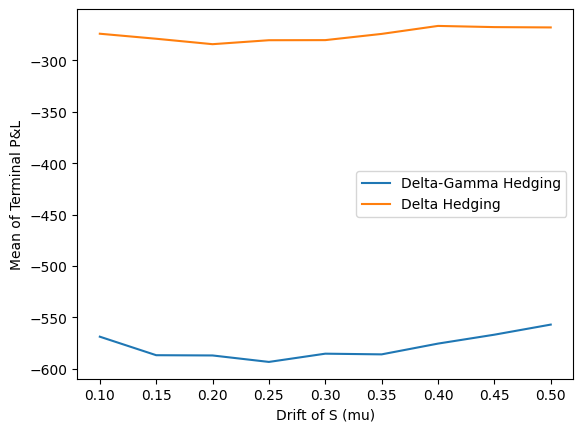

In [7]:
means_d = [np.mean(profits_mu_d[i]) for i in range(9)]
std_d = [np.std(profits_mu_d[i]) for i in range(9)]
means_dg = [np.mean(profits_mu_dg[i]) for i in range(9)]
std_dg = [np.std(profits_mu_dg[i]) for i in range(9)]

plt.plot(mus, std_dg, label="Delta-Gamma Hedging")
plt.plot(mus, std_d, label="Delta Hedging")
plt.ylabel("Standard Deivation of Terminal P&L")
plt.xlabel("Drift of S (mu)")
plt.legend()
plt.show()

plt.plot(mus, means_dg, label="Delta-Gamma Hedging")
plt.plot(mus, means_d, label="Delta Hedging")
plt.ylabel("Mean of Terminal P&L")
plt.xlabel("Drift of S (mu)")
plt.legend()
plt.show()

In [9]:
sigmas = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3]
profits_sig_d = []
profits_sig_dg = []
k= 0.005

for sig in sigmas:
    a, b = get_profits(sig, k)
    profits_sig_d.append(a)
    profits_sig_dg.append(b)

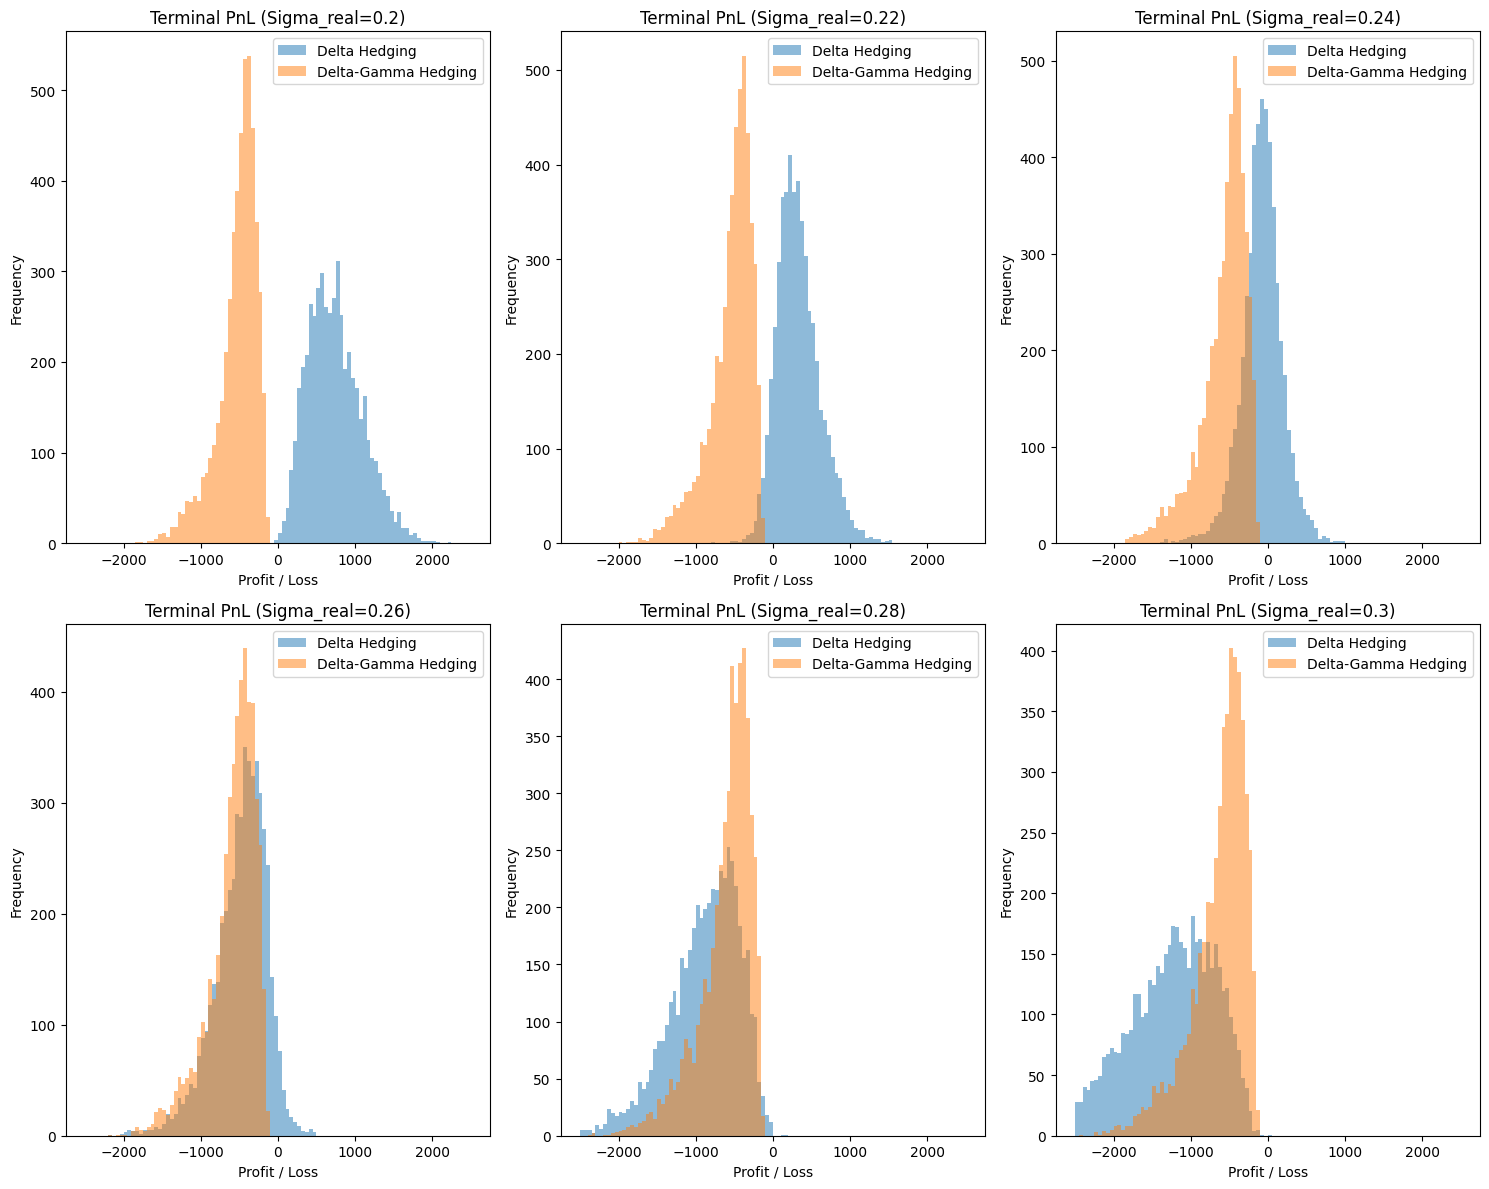

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

for i in range(len(sigmas)):
    row = i // 3
    col = i % 3

    axs[row, col].hist(profits_sig_d[i], bins=np.linspace(-2500, 2500, 101), alpha=0.5, label='Delta Hedging')
    axs[row, col].hist(profits_sig_dg[i], bins=np.linspace(-2500, 2500, 101), alpha=0.5, label='Delta-Gamma Hedging')
    axs[row, col].set_xlabel('Profit / Loss')
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_title(f'Terminal PnL (Sigma_real={sigmas[i]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

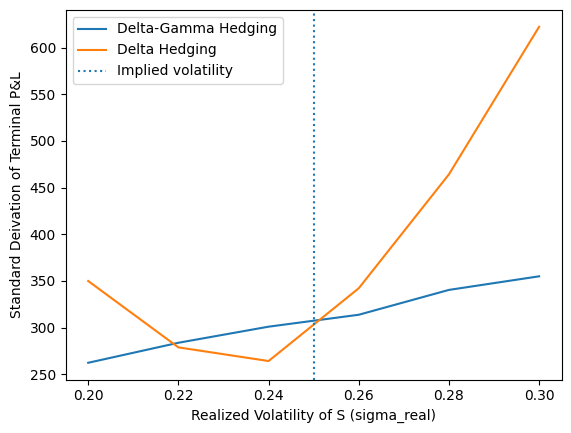

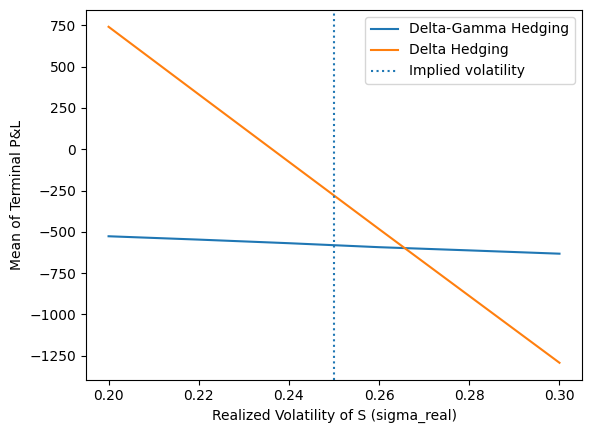

In [24]:
means_d = [np.mean(profits_sig_d[i]) for i in range(6)]
std_d = [np.std(profits_sig_d[i]) for i in range(6)]
means_dg = [np.mean(profits_sig_dg[i]) for i in range(6)]
std_dg = [np.std(profits_sig_dg[i]) for i in range(6)]

plt.plot(sigmas, std_dg, label="Delta-Gamma Hedging")
plt.plot(sigmas, std_d, label="Delta Hedging")
plt.axvline(x=0.25, linestyle = ":", label = "Implied volatility")

plt.ylabel("Standard Deivation of Terminal P&L")
plt.xlabel("Realized Volatility of S (sigma_real)")
plt.legend()
plt.show()

plt.plot(sigmas, means_dg, label="Delta-Gamma Hedging")
plt.plot(sigmas, means_d, label="Delta Hedging")
plt.axvline(x=0.25, linestyle = ":", label = "Implied volatility")

plt.ylabel("Mean of Terminal P&L")
plt.xlabel("Realized Volatility of S (sigma_real)")
plt.legend()
plt.show()